Function: F1
Execution Time: 4.17234992980957 seconds
Flamingo Search Best Solution: [ 0.33234669  0.19054239 -0.10936872 -0.64744717 -0.79492364 -0.24705912
  0.4265614   0.5279279  -0.48408782 -0.19530804 -0.41429802  0.39215381
 -1.28846665  0.15352481  0.11584042  0.49464306 -0.29459449 -0.0353662
  1.08013748  0.25470727  0.20885131 -0.35455278  0.08422118  0.16576522
  0.59769188 -0.22137665  0.5366773   0.35085007  0.09235233  0.04219996
 -0.2589341   0.0552562   0.36121953  0.52592538  0.05452022  0.58180232
  0.4562694   0.5644935   0.06785122  0.1131227   0.15522504 -0.21350649
 -0.01907568  1.01562301  0.01984884 -0.4264306   0.08799205 -0.05854615
 -0.58572348  0.1484611 ] Objective Value: 9.645346162299854
Genetic Algorithm Best Solution: [ 0.10848599  0.39403861 -0.44097555 -0.05130351 -0.12438985 -0.17552287
  0.06158892  0.0080503  -0.05026025 -0.30877049  0.20639299 -0.2281506
  0.06667023  0.35120341  0.1804008   0.03765621  0.04731127  0.38876197
  0.14004295 -0.4435

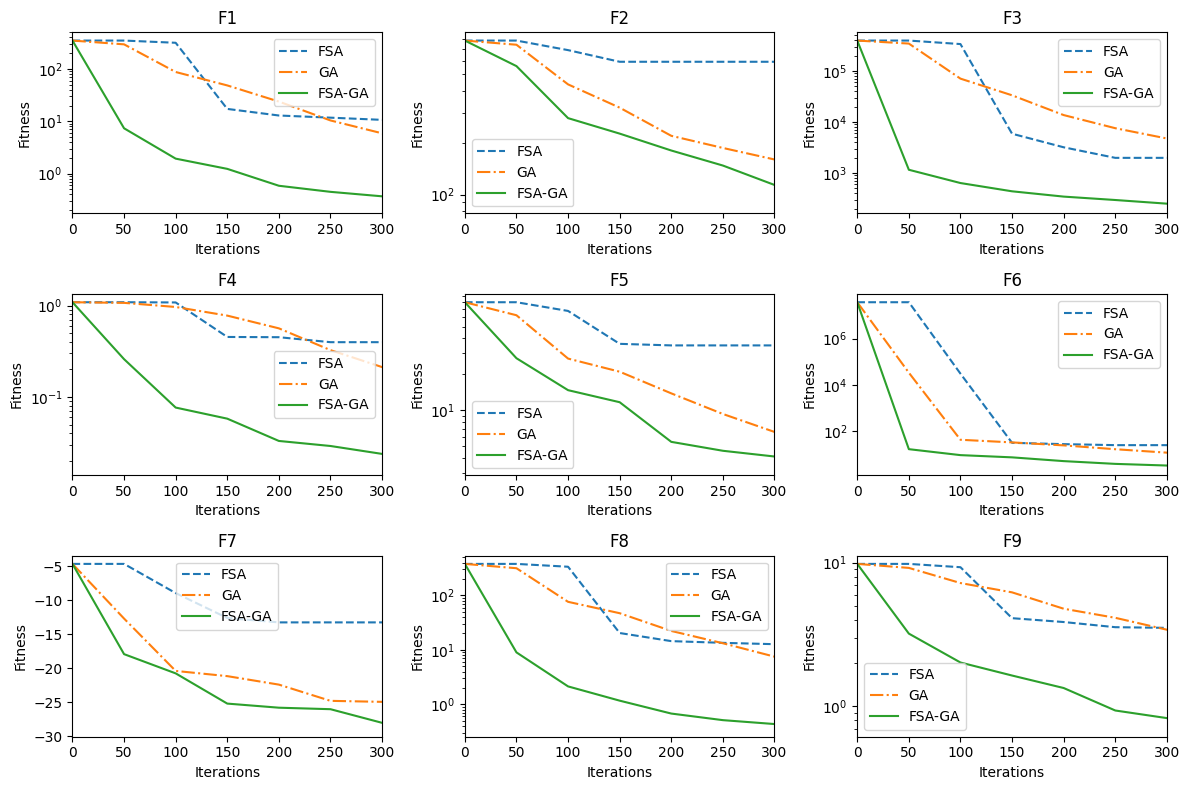

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math

# Objective functions
def F1(x):
    return np.sum(x**2)

def F2(x):
    A = 10
    return A * len(x) + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in x])

def F3(x):
    return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

def F4(x):
    return 1/4000 * np.sum(x**2) - np.prod(np.cos(x / np.sqrt(np.arange(1, len(x) + 1)))) + 1

def F5(x):
    return np.sum(np.abs(x * np.sin(x) + 0.1 * x))

def F6(x):
    sum = 0
    sum1 = 1
    for i in range(len(x)):
        sum += np.abs(x[i])
        sum1 *= np.abs(x[i])
    return sum + sum1

def F7(x):
    m = 10
    return -np.sum(np.sin(x) * np.sin(((np.arange(1, len(x) + 1) * x**2) / np.pi)**(2 * m)))

def F8(x):
    sum = 0
    for i in range(len(x)):
        sum += (x[i] + 0.5) * (x[i] + 0.5)
    return sum

def F9(x):
    n = len(x)
    return -20 * np.exp(-0.2 * np.sqrt(np.sum(x**2) / n)) - np.exp(np.sum(np.cos(2 * np.pi * x)) / n) + 20 + np.exp(1)

# Flamingo Search Algorithm
def flamingo_search(objective_function, initial_solution, n_iter, n_flamingos, sigma):
    best_solution = initial_solution
    best_objective_value = objective_function(best_solution)
    convergence = [best_objective_value]

    for i in range(n_iter):
        flamingos = [best_solution + np.random.normal(scale=sigma, size=len(best_solution)) for _ in range(n_flamingos)]
        for f in flamingos:
            f_value = objective_function(f)
            if f_value < best_objective_value:
                best_solution = f
                best_objective_value = f_value
        if i % 50 == 0:
            convergence.append(best_objective_value)

    convergence.append(best_objective_value)  # Final value at iteration 100
    return best_solution, convergence

# Genetic Algorithm Functions
def create_population(size, dim, lb=-5, ub=5):
    return np.random.uniform(lb, ub, (size, dim))

def fitness_function(population, objective_function):
    fitness = np.array([objective_function(ind) for ind in population])
    fitness_prob = 1 / (fitness + 1e-10)  # Inverse of objective value
    fitness_prob -= np.min(fitness_prob)  # Make sure all probabilities are non-negative
    fitness_prob /= np.sum(fitness_prob)  # Normalize to make sum of probabilities equal to 1
    return fitness_prob

def selection(population, fitness, num_parents):
    parents_idx = np.random.choice(len(population), size=num_parents, replace=False, p=fitness)
    return population[parents_idx]

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        crossover_point = np.random.randint(1, offspring_size[1] - 1)
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover, mutation_rate=0.1):
    for idx in range(offspring_crossover.shape[0]):
        if np.random.rand() < mutation_rate:
            random_index = np.random.randint(0, offspring_crossover.shape[1])
            offspring_crossover[idx, random_index] += np.random.normal()
    return offspring_crossover

# Function to format results
def format_results(fs_convergence, ga_convergence, fsga_convergence):
    results = []
    for i in [100, 200, 300]:
        fs_fitness = fs_convergence[i // 50]
        ga_fitness = ga_convergence[i // 50]
        fsga_fitness = fsga_convergence[i // 50]
        results.append(f"{i}\t{ga_fitness}\t{fs_fitness}\t{fsga_fitness}")
    return results

def genetic_algorithm(population, objective_function, generations, mutation_rate=0.1, elitism_rate=0.1):
    convergence = []
    best_objective_value = np.inf

    for gen in range(generations):
        fitness = fitness_function(population, objective_function)
        parents = selection(population, fitness, len(population) // 2)
        offspring_crossover = crossover(parents, (len(population) - len(parents), population.shape[1]))
        offspring_mutation = mutation(offspring_crossover, mutation_rate)
        population[len(parents):] = offspring_mutation

        # Elitism: Keep top elitism_rate * 100% individuals
        num_elites = int(elitism_rate * len(population))
        elites = population[np.argsort([objective_function(ind) for ind in population])[:num_elites]]
        population[:num_elites] = elites

        best_solution = population[np.argmin([objective_function(ind) for ind in population])]
        current_best_value = objective_function(best_solution)
        if current_best_value < best_objective_value:
            best_objective_value = current_best_value
        if gen % 50 == 0:
            convergence.append(best_objective_value)

    convergence.append(best_objective_value)  # Final value at iteration 100
    return best_solution, convergence


# Flamingo Search and Genetic Algorithm Combined
def flamingo_genetic_search(objective_function, initial_solution, n_iter, n_flamingos, sigma, generations, population_size):
    # Flamingo Search
    fs_best_solutions = [flamingo_search(objective_function, initial_solution, n_iter, n_flamingos, sigma)[0] for _ in range(10)]
    # Create population from best solutions found by FSA
    population = create_population(population_size, len(initial_solution))
    population[:10] = fs_best_solutions
    # Apply GA on initial population from FSA
    best_solution, convergence = genetic_algorithm(population, objective_function, generations)
    return best_solution, convergence


# Main Loop to Test All Functions
functions = [F1, F2, F3, F4, F5, F6, F7, F8, F9]
function_names = ["F1", "F2", "F3", "F4", "F5", "F6", "F7" , "F8", "F9"]

n_iter = 300  # Number of iterations for FSA
n_flamingos = 100  # Number of Flamingos
sigma = 0.5  # Step size in FSA
generations = 300  # Number of generations for GA
population_size = 100  # Population size for GA
dim = 50  # Dimension of the problem
lb = -5
ub = 5

fig, axs = plt.subplots(3, 3, figsize=(12, 8))
axs = axs.ravel()

for i, (func, func_name) in enumerate(zip(functions, function_names)):
    # Step 0: Initial random solutions and select the best
    initial_population = create_population(10, dim)
    initial_objective_values = np.array([func(ind) for ind in initial_population])
    best_initial_index = np.argmin(initial_objective_values)
    initial_solution = initial_population[best_initial_index]
    initial_value = initial_objective_values[best_initial_index]

    time_start = time.time()

    # Flamingo Search
    fs_best_solution, fs_convergence = flamingo_search(func, initial_solution, n_iter, n_flamingos, sigma)
    fs_convergence.insert(0, initial_value)  # Insert initial value at the beginning

    # Genetic Algorithm
    population = create_population(population_size, dim)
    population[0] = initial_solution  # Ensure starting from the same initial solution
    ga_best_solution, ga_convergence = genetic_algorithm(population, func, generations)
    ga_convergence.insert(0, initial_value)  # Insert initial value at the beginning

    # Flamingo Search and Genetic Algorithm Mixed
    fsga_best_solution, fsga_convergence = flamingo_genetic_search(func, initial_solution, n_iter, n_flamingos, sigma, generations, population_size)
    fsga_convergence.insert(0, initial_value)  # Insert initial value at the beginning

    time_end = time.time()

    # Print Results
    print(f"Function: {func_name}")
    print("Execution Time:", time_end - time_start, "seconds")
    print("Flamingo Search Best Solution:", fs_best_solution, "Objective Value:", func(fs_best_solution))
    print("Genetic Algorithm Best Solution:", ga_best_solution, "Objective Value:", func(ga_best_solution))
    print("Flamingo Search and Genetic Algorithm Mixed Best Solution:", fsga_best_solution, "Objective Value:", func(fsga_best_solution))

    # Format and print results for iterations 100, 200, 300
    formatted_results = format_results(fs_convergence, ga_convergence, fsga_convergence)
    print("Iteration\t100\t200\t300")
    for result in formatted_results:
        print(func_name + "_" + result)
    
    # Plot Convergence Comparison
    x_points = np.arange(0, len(fs_convergence) * 50, 50)  # Adjust x_points to match the interval

    # Check lengths of convergence arrays and adjust if necessary
    convergence_arrays = [fs_convergence, ga_convergence, fsga_convergence]
    min_length = min(map(len, convergence_arrays))
    convergence_arrays = [arr[:min_length] for arr in convergence_arrays]
    x_points = x_points[:min_length]

    axs[i].plot(x_points, convergence_arrays[0], label='FSA', linestyle='--')
    axs[i].plot(x_points, convergence_arrays[1], label='GA', linestyle='-.')
    axs[i].plot(x_points, convergence_arrays[2], label='FSA-GA')
    axs[i].set_title(func_name)
    axs[i].set_xlabel('Iterations')
    axs[i].set_ylabel('Fitness')    
    if func_name != "F7":
        axs[i].set_yscale('log')  
    axs[i].legend()
    axs[i].set_xlim(0, 300)

plt.tight_layout()
plt.show()


Function: F1
Execution Time: 3.36116623878479 seconds
Flamingo Search Best Solution: [ 0.17111661 -0.53744047  0.01916478  0.09864598 -0.57220063 -0.58184879
 -0.45983256  0.27179878  0.18154098 -0.01389527 -0.59102106 -0.20701577
  0.12951379  0.10705156 -0.13492726  0.68178648 -0.16298635 -0.2726269
 -0.43967632 -0.29475144  0.62133768  0.80640756  0.20304989 -0.06286013
  0.08251599  0.54600744  0.29783134  0.13830783  0.6386249   0.66720336
 -0.51106991 -0.23745151 -0.18062451  0.26790914 -0.88543434  0.08773544
  0.0917184   0.05867692 -0.09877334 -0.07400001  0.39848069  0.40609943
  0.05205664  0.80477287 -0.49242244 -0.25083274 -0.13222437  0.24828879
  0.50332355 -0.29657536] Objective Value: 7.885119935736829
Genetic Algorithm Best Solution: [-0.19359334  0.19161351  0.10186329 -0.12553124 -0.12971588 -0.26889716
  0.37336543 -0.13913646 -0.2722478   0.06120951  0.2776677   0.23071183
 -0.37470447 -0.17210894 -0.30376883  0.27963556  0.30178904 -0.34025597
  0.1338599  -0.218

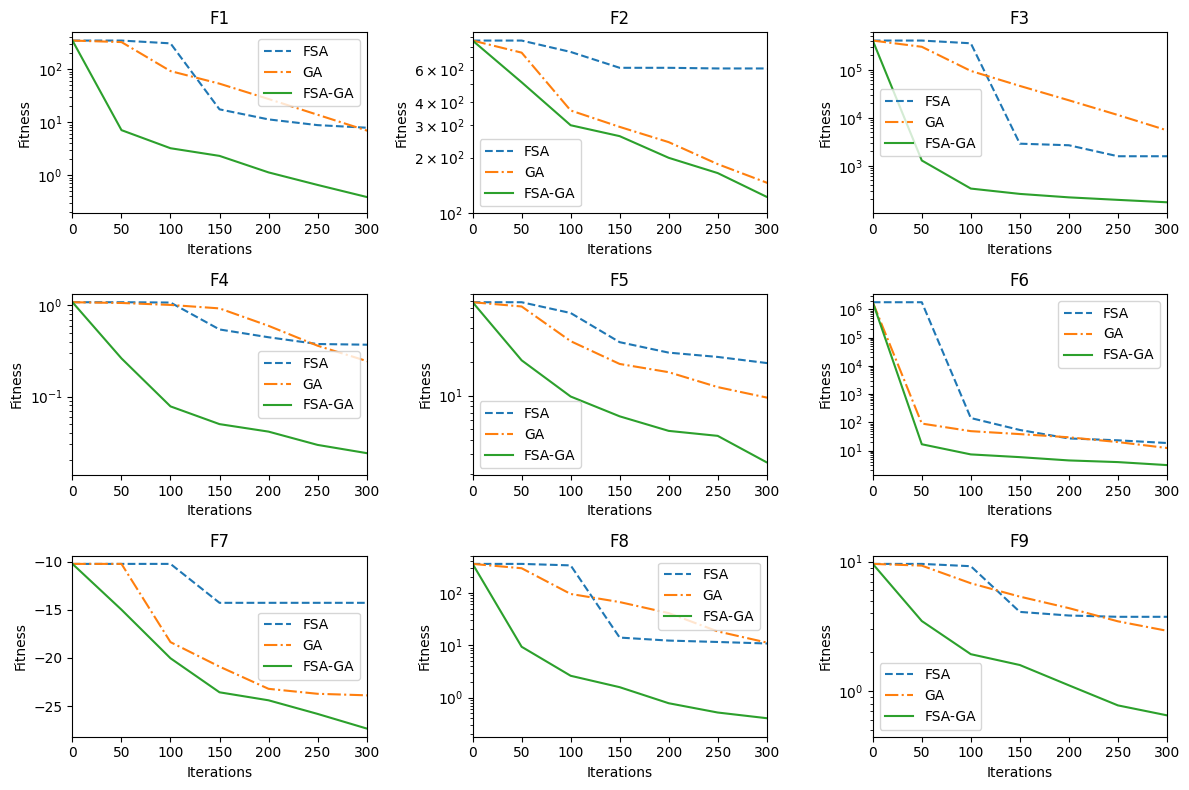

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math

# Objective functions
def F1(x):
    return np.sum(x**2)

def F2(x): #change with other functions

    A = 10  # Modify this constant as needed
    return A * len(x) + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in x])

def F3(x):
    return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

def F4(x):
    return 1/4000 * np.sum(x**2) - np.prod(np.cos(x / np.sqrt(np.arange(1, len(x) + 1)))) + 1

def F5(x):  # Alpine Function
    return np.sum(np.abs(x * np.sin(x) + 0.1 * x))


def F6(x):
    sum=0
    sum1=1
    for i in range(len(x)):
        sum+=np.abs(x[i])
        sum1*=np.abs(x[i])
    return sum+sum1

def F7(x):  # Michalewicz Function
    m = 10
    return -np.sum(np.sin(x) * np.sin(((np.arange(1, len(x) + 1) * x**2) / np.pi)**(2 * m)))


def F8(x):
    sum=0
    for i in range(len(x)):
        sum+=(x[i]+0.5)*(x[i]+0.5)
    return sum

def F9(x):
    n = len(x)
    return -20 * np.exp(-0.2 * np.sqrt(np.sum(x**2) / n)) - np.exp(np.sum(np.cos(2 * np.pi * x)) / n) + 20 + np.exp(1)

# Flamingo Search Algorithm
def flamingo_search(objective_function, initial_solution, n_iter, n_flamingos, sigma):
    best_solution = initial_solution
    best_objective_value = objective_function(best_solution)
    convergence = [best_objective_value]

    for i in range(n_iter):
        flamingos = [best_solution + np.random.normal(scale=sigma, size=len(best_solution)) for _ in range(n_flamingos)]
        for f in flamingos:
            f_value = objective_function(f)
            if f_value < best_objective_value:
                best_solution = f
                best_objective_value = f_value
        if i % 50 == 0:
            convergence.append(best_objective_value)

    convergence.append(best_objective_value)  # Final value at iteration 100
    return best_solution, convergence

# Genetic Algorithm Functions
def create_population(size, dim, lb=-5, ub=5):
    return np.random.uniform(lb, ub, (size, dim))

def fitness_function(population, objective_function):
    fitness = np.array([objective_function(ind) for ind in population])
    fitness_prob = 1 / (fitness + 1e-10)  # Inverse of objective value
    fitness_prob -= np.min(fitness_prob)  # Make sure all probabilities are non-negative
    fitness_prob /= np.sum(fitness_prob)  # Normalize to make sum of probabilities equal to 1
    return fitness_prob

def selection(population, fitness, num_parents):
    parents_idx = np.random.choice(len(population), size=num_parents, replace=False, p=fitness)
    return population[parents_idx]

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        crossover_point = np.random.randint(1, offspring_size[1] - 1)
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover, mutation_rate=0.1):
    for idx in range(offspring_crossover.shape[0]):
        if np.random.rand() < mutation_rate:
            random_index = np.random.randint(0, offspring_crossover.shape[1])
            offspring_crossover[idx, random_index] += np.random.normal()
    return offspring_crossover

# def genetic_algorithm(population, objective_function, generations, mutation_rate=0.1, elitism_rate=0.1):
#     convergence = []
#     best_objective_value = np.inf

#     for gen in range(generations):
#         fitness = fitness_function(population, objective_function)
#         parents = selection(population, fitness, len(population) // 2)
#         offspring_crossover = crossover(parents, (len(population) - len(parents), population.shape[1]))
#         offspring_mutation = mutation(offspring_crossover, mutation_rate)
#         population[:len(parents)] = parents
#         population[len(parents):] = offspring_mutation

#         # Elitism
#         num_elites = int(elitism_rate * len(population))
#         elites = population[np.argsort([objective_function(ind) for ind in population])[:num_elites]]
#         population[:num_elites] = elites

#         best_solution = population[np.argmin([objective_function(ind) for ind in population])]
#         current_best_value = objective_function(best_solution)
#         if current_best_value < best_objective_value:
#             best_objective_value = current_best_value
#         if gen % 50 == 0:
#             convergence.append(best_objective_value)

#     convergence.append(best_objective_value)  # Final value at iteration 100
#     return best_solution, convergence

# Function to format results
def format_results(fs_convergence, ga_convergence, fsga_convergence):
    results = []
    for i in [100, 200, 300]:
        fs_fitness = fs_convergence[i // 50]
        ga_fitness = ga_convergence[i // 50]
        fsga_fitness = fsga_convergence[i // 50]
        results.append(f"{i}\t{ga_fitness}\t{fs_fitness}\t{fsga_fitness}")
    return results
def genetic_algorithm(population, objective_function, generations, mutation_rate=0.1, elitism_rate=0.1):
    convergence = []
    best_objective_value = np.inf

    for gen in range(generations):
        fitness = fitness_function(population, objective_function)
        parents = selection(population, fitness, len(population) // 2)
        offspring_crossover = crossover(parents, (len(population) - len(parents), population.shape[1]))
        offspring_mutation = mutation(offspring_crossover, mutation_rate)
        population[len(parents):] = offspring_mutation

        # Elitism: Keep top elitism_rate * 100% individuals
        num_elites = int(elitism_rate * len(population))
        elites = population[np.argsort([objective_function(ind) for ind in population])[:num_elites]]
        population[:num_elites] = elites

        best_solution = population[np.argmin([objective_function(ind) for ind in population])]
        current_best_value = objective_function(best_solution)
        if current_best_value < best_objective_value:
            best_objective_value = current_best_value
        if gen % 50 == 0:
            convergence.append(best_objective_value)

    convergence.append(best_objective_value)  # Final value at iteration 100
    return best_solution, convergence


# Flamingo Search and Genetic Algorithm Combined
def flamingo_genetic_search(objective_function, initial_solution, n_iter, n_flamingos, sigma, generations, population_size):
    # Flamingo Search
    fs_best_solutions = [flamingo_search(objective_function, initial_solution, n_iter, n_flamingos, sigma)[0] for _ in range(10)]
    # Create population from best solutions found by FSA
    population = create_population(population_size, len(initial_solution))
    population[:10] = fs_best_solutions
    # Apply GA on initial population from FSA
    best_solution, convergence = genetic_algorithm(population, objective_function, generations)
    return best_solution, convergence
#------------------------------------------------------------------------------------------------------------------------------------------------------
# # Main Loop to Test All Functions
# functions = [F1, F2, F3, F4, F5, F6, F7, F8, F9]
# function_names = ["F1", "F2", "F3", "F4", "F5", "F6", "F7" , "F8", "F9"]

# n_iter = 300  # Number of iterations for FSA
# n_flamingos = 100  # Number of Flamingos
# sigma = 0.5  # Step size in FSA
# generations = 300  # Number of generations for GA
# population_size = 100  # Population size for GA
# dim = 10  # Dimension of the problem
# lb = -5
# ub = 10

# fig, axs = plt.subplots(3, 3, figsize=(12, 8))
# axs = axs.ravel()

# for i, (func, func_name) in enumerate(zip(functions, function_names)):
#     # Step 0: Initial random solutions and select the best
#     initial_population = create_population(10, dim)
#     initial_objective_values = np.array([func(ind) for ind in initial_population])
#     best_initial_index = np.argmin(initial_objective_values)
#     initial_solution = initial_population[best_initial_index]
#     initial_value = initial_objective_values[best_initial_index]

#     time_start = time.time()

#     # Flamingo Search
#     fs_best_solution, fs_convergence = flamingo_search(func, initial_solution, n_iter, n_flamingos, sigma)
#     fs_convergence.insert(0, initial_value)  # Insert initial value at the beginning

#     # Genetic Algorithm
#     population = create_population(population_size, dim)
#     population[0] = initial_solution  # Ensure starting from the same initial solution
#     ga_best_solution, ga_convergence = genetic_algorithm(population, func, generations)
#     ga_convergence.insert(0, initial_value)  # Insert initial value at the beginning

#     # Flamingo Search and Genetic Algorithm Mixed
#     fsga_best_solution, fsga_convergence = flamingo_genetic_search(func, initial_solution, n_iter, n_flamingos, sigma, generations, population_size)
#     fsga_convergence.insert(0, initial_value)  # Insert initial value at the beginning

#     time_end = time.time()

#     # Print Results
#     print(f"Function: {func_name}")
#     print("Execution Time:", time_end - time_start, "seconds")
#     print("Flamingo Search Best Solution:", fs_best_solution, "Objective Value:", func(fs_best_solution))
#     print("Genetic Algorithm Best Solution:", ga_best_solution, "Objective Value:", func(ga_best_solution))
#     print("Flamingo Search and Genetic Algorithm Mixed Best Solution:", fsga_best_solution, "Objective Value:", func(fsga_best_solution))

#     # Format and print results for iterations 100, 200, 300
#     formatted_results = format_results(fs_convergence, ga_convergence, fsga_convergence)
#     print("Interation\t100\t200\t300")
#     for result in formatted_results:
#         print(func_name + "_" + result)
#     # Plot Convergence Comparison
#     x_points = np.arange(0, len(fs_convergence) * 50, 50)  # Adjust x_points to match the interval

#     # Check lengths of convergence arrays and adjust if necessary
#     convergence_arrays = [fs_convergence, ga_convergence, fsga_convergence]
#     min_length = min(map(len, convergence_arrays))
#     convergence_arrays = [arr[:min_length] for arr in convergence_arrays]
#     x_points = x_points[:min_length]

#     axs[i].plot(x_points, convergence_arrays[0], label='FSA', linestyle='--')
#     axs[i].plot(x_points, convergence_arrays[1], label='GA', linestyle='-.')
#     axs[i].plot(x_points, convergence_arrays[2], label='FSA-GA')
#     axs[i].set_title(func_name)
#     axs[i].set_xlabel('Iterations')
#     axs[i].set_ylabel('Fitness')    
#     if func_name != "F7":
#         axs[i].set_yscale('log')  
#     axs[i].legend()
#     axs[i].set_xlim(0, 300)


# plt.tight_layout()
# plt.show()



# Function to format results for Iteration 100, 200, 300
def format_results(fs_convergence, ga_convergence, fsga_convergence):
    results = []
    for i in [100, 200, 300]:
        fs_fitness = fs_convergence[i // 50]
        ga_fitness = ga_convergence[i // 50]
        fsga_fitness = fsga_convergence[i // 50]
        results.append(f"Iteration {i}\tFSA: {fs_fitness:.4e}\tGA: {ga_fitness:.4e}\tFSA-GA: {fsga_fitness:.4e}")
    return results

# Main Loop to Test All Functions
functions = [F1, F2, F3, F4, F5, F6, F7, F8, F9]
function_names = ["F1", "F2", "F3", "F4", "F5", "F6", "F7" , "F8", "F9"]

n_iter = 300  # Number of iterations for FSA
n_flamingos = 100  # Number of Flamingos
sigma = 0.5  # Step size in FSA
generations = 300  # Number of generations for GA
population_size = 100  # Population size for GA
dim = 50  # Dimension of the problem
lb = -5
ub = 10

fig, axs = plt.subplots(3, 3, figsize=(12, 8))
axs = axs.ravel()

for i, (func, func_name) in enumerate(zip(functions, function_names)):
    # Step 0: Initial random solutions and select the best
    initial_population = create_population(10, dim)
    initial_objective_values = np.array([func(ind) for ind in initial_population])
    best_initial_index = np.argmin(initial_objective_values)
    initial_solution = initial_population[best_initial_index]
    initial_value = initial_objective_values[best_initial_index]

    time_start = time.time()

    # Flamingo Search
    fs_best_solution, fs_convergence = flamingo_search(func, initial_solution, n_iter, n_flamingos, sigma)
    fs_convergence.insert(0, initial_value)  # Insert initial value at the beginning

    # Genetic Algorithm
    population = create_population(population_size, dim)
    population[0] = initial_solution  # Ensure starting from the same initial solution
    ga_best_solution, ga_convergence = genetic_algorithm(population, func, generations)
    ga_convergence.insert(0, initial_value)  # Insert initial value at the beginning

    # Flamingo Search and Genetic Algorithm Mixed
    fsga_best_solution, fsga_convergence = flamingo_genetic_search(func, initial_solution, n_iter, n_flamingos, sigma, generations, population_size)
    fsga_convergence.insert(0, initial_value)  # Insert initial value at the beginning

    time_end = time.time()

    # Print Results
    print(f"Function: {func_name}")
    print("Execution Time:", time_end - time_start, "seconds")
    print("Flamingo Search Best Solution:", fs_best_solution, "Objective Value:", func(fs_best_solution))
    print("Genetic Algorithm Best Solution:", ga_best_solution, "Objective Value:", func(ga_best_solution))
    print("Flamingo Search and Genetic Algorithm Mixed Best Solution:", fsga_best_solution, "Objective Value:", func(fsga_best_solution))

    # Format and print results for iterations 100, 200, 300
    formatted_results = format_results(fs_convergence, ga_convergence, fsga_convergence)
    print("Iteration\t\tFSA\t\tGA\t\tFSA-GA")
    for result in formatted_results:
        print(result)  # Printing the detailed iteration results

    # Plot Convergence Comparison
    x_points = np.arange(0, len(fs_convergence) * 50, 50)  # Adjust x_points to match the interval

    # Check lengths of convergence arrays and adjust if necessary
    convergence_arrays = [fs_convergence, ga_convergence, fsga_convergence]
    min_length = min(map(len, convergence_arrays))
    convergence_arrays = [arr[:min_length] for arr in convergence_arrays]
    x_points = x_points[:min_length]

    axs[i].plot(x_points, convergence_arrays[0], label='FSA', linestyle='--')
    axs[i].plot(x_points, convergence_arrays[1], label='GA', linestyle='-.')
    axs[i].plot(x_points, convergence_arrays[2], label='FSA-GA')
    axs[i].set_title(func_name)
    axs[i].set_xlabel('Iterations')
    axs[i].set_ylabel('Fitness')    
    if func_name != "F7":
        axs[i].set_yscale('log')  
    axs[i].legend()
    axs[i].set_xlim(0, 300)

plt.tight_layout()
plt.show()
